In [1]:
from google.colab import drive
drive.mount('/content/drive')

rawdata_path = '/content/drive/MyDrive/my_project/my_project1/rawdata'
data_path = '/content/drive/MyDrive/my_project/my_project1/data'
final_result = '/content/drive/MyDrive/my_project/my_project1/result/reg'
final_img = '/content/drive/MyDrive/my_project/my_project1/result/img'
final_sang = '/content/drive/MyDrive/my_project/my_project1/result/sang'
# rawdata_path = 'rawdata/'
# data_path = 'data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# # 1. 나눔 폰트 다운
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import geopandas as gpd

import statsmodels.api as sm
import re
from io import StringIO

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")

In [4]:
year_list = ['2022', '2023', '2024']

for year in year_list:
    globals()[f'temp_{year}'] = pd.read_csv(f'{data_path}/final/final_{year}.csv')
    globals()[f'temp_{year}'] = globals()[f'temp_{year}'].replace('-', '0')


In [5]:
depend_list = ['solo_all_ratio', 'solo_20s_ratio', 'solo_30s_ratio']
depend_name = ['all', '20', '30']

In [6]:
var_col = ['네일숍', '미용실', '애완동물',
           '분식전문점', '한식음식점', '양식음식점', '일식음식점', '중식음식점', '치킨전문점',
           '커피-음료', '패스트푸드점', '제과점', '호프-간이주점',
            '대형마트', '쇼핑업체수', '편의점', '슈퍼마켓']

nocal_col = ['사업체수', '종사자수', '지가변동률', '지가', '대학교', '기타대학' ]

drop_col = [ '면적', '월평균소득', '총상주인구', '20대상주인구', '총직장인구', '20대직장인구', '유통업체수']

reg_col = ['ADM_CD'] + depend_list + var_col + nocal_col

In [7]:
for year in year_list:
    df = globals()[f'temp_{year}'].copy()

    # df 칼럼 정리
    # 변수명 뒤에 연도 써있는 변수들 제거
    columns_2022 = [col.replace('_2022', '') for col in df.columns]
    columns_2023 = [col.replace('_2023', '') for col in columns_2022]
    columns_2024 = [col.replace('_2024', '') for col in columns_2023]
    df.columns = columns_2024
    globals()[f'df_{year}'] = df.copy()

    reg = df[reg_col + ['total_all']]
    # 인구 1만명당 변수 확인
    for var in var_col:
        reg[var] = reg[var] / reg['total_all'] * 10000

    reg.drop(columns = 'total_all', inplace=True)
    globals()[f'reg_{year}'] = reg.copy()


In [8]:
temp_2022.head()

,ADM_CD,total_all_2022,solo_all_2022,total_20_2022,solo_20_2022,total_25_2022,solo_25_2022,total_30_2022,solo_30_2022,total_35_2022,...,총매출금액_양식음식점_2022,총매출금액_일식음식점_2022,총매출금액_제과점_2022,총매출금액_중식음식점_2022,총매출금액_치킨전문점_2022,총매출금액_커피-음료_2022,총매출금액_패스트푸드점_2022,총매출금액_편의점_2022,총매출금액_한식음식점_2022,총매출금액_호프-간이주점_2022
0,11010530,7848.0,1854.0,582.0,183.0,687.0,220.0,779.0,244.0,758.0,...,2.700544e+09,4.009334e+09,1.024866e+09,2.067096e+09,151123891.0,8.715381e+09,749006078.0,4.259033e+09,2.279076e+10,1.627539e+09
1,11010540,2384.0,831.0,156.0,78.0,172.0,90.0,193.0,90.0,211.0,...,3.243627e+09,2.692862e+07,6.108442e+08,0.000000e+00,0.0,4.847156e+09,7462031.0,4.966037e+08,4.833707e+09,1.334099e+08
2,11010550,9116.0,1530.0,1147.0,201.0,841.0,154.0,711.0,181.0,652.0,...,1.901209e+08,0.000000e+00,2.658687e+08,4.502295e+07,27441593.0,4.592954e+08,107221827.0,7.261664e+08,5.864678e+08,1.911793e+07
3,11010560,15369.0,1604.0,1269.0,132.0,1173.0,127.0,1172.0,144.0,1075.0,...,1.062373e+08,1.879954e+07,3.815037e+08,2.886612e+08,0.0,5.489234e+08,0.0,4.087258e+08,2.379329e+09,1.762930e+08
4,11030740,18531.0,5332.0,1138.0,439.0,1829.0,748.0,2393.0,897.0,2037.0,...,8.993222e+09,1.640832e+09,5.732351e+08,9.877729e+08,770611211.0,2.705864e+09,228290638.0,3.617802e+09,1.480354e+10,2.165285e+09


In [9]:
df_2023.head()

,ADM_CD,total_all,solo_all,total_20,solo_20,total_25,solo_25,total_30,solo_30,total_35,...,총매출금액_양식음식점,총매출금액_일식음식점,총매출금액_제과점,총매출금액_중식음식점,총매출금액_치킨전문점,총매출금액_커피-음료,총매출금액_패스트푸드점,총매출금액_편의점,총매출금액_한식음식점,총매출금액_호프-간이주점
0,11010530,7845.0,1869.0,583.0,172.0,686.0,241.0,778.0,222.0,757.0,...,5.351868e+09,5.112117e+09,1.203470e+09,2.749773e+09,673323360.0,1.187346e+10,902523398.0,5.084405e+09,3.660644e+10,3.245160e+09
1,11010540,2370.0,800.0,143.0,68.0,172.0,85.0,193.0,92.0,211.0,...,4.447327e+09,2.441660e+07,1.178688e+09,0.000000e+00,0.0,6.900190e+09,111870248.0,5.324073e+08,7.375948e+09,2.476535e+08
2,11010550,9116.0,1549.0,1147.0,213.0,841.0,154.0,711.0,187.0,652.0,...,3.769157e+08,0.000000e+00,3.140562e+08,5.614901e+07,0.0,4.776125e+08,189999970.0,8.978345e+08,7.587584e+08,2.295424e+07
3,11010560,15369.0,1617.0,1269.0,136.0,1173.0,123.0,1172.0,143.0,1075.0,...,7.416936e+07,1.221249e+07,3.463709e+08,2.517208e+08,0.0,9.633955e+08,284394280.0,3.962739e+08,2.456528e+09,2.872706e+08
4,11030740,18463.0,5314.0,1138.0,442.0,1823.0,743.0,2384.0,881.0,2035.0,...,1.119020e+10,1.989825e+09,5.286337e+08,1.512627e+09,910011062.0,4.049663e+09,415945610.0,4.542987e+09,2.130260e+10,3.918752e+09


In [10]:
reg_2023.head()

,ADM_CD,solo_all_ratio,solo_20s_ratio,solo_30s_ratio,네일숍,미용실,애완동물,분식전문점,한식음식점,양식음식점,...,대형마트,쇼핑업체수,편의점,슈퍼마켓,사업체수,종사자수,지가변동률,지가,대학교,기타대학
0,11010530,23.824092,11.048689,12.092028,16.571064,40.790312,10.197578,158.062460,527.724665,231.994901,...,0.0,0.0,14.021670,0.000000,4994,56046,7.902167,98.973167,0.0,0.0
1,11010540,33.755274,9.562500,11.437500,8.438819,0.000000,0.000000,71.729958,308.016878,358.649789,...,0.0,0.0,4.219409,0.000000,970,5118,7.840571,99.057857,0.0,0.0
2,11010550,16.992102,11.846352,10.942544,0.000000,10.969724,7.678806,15.357613,41.684950,40.587977,...,0.0,0.0,4.387889,0.000000,908,4140,8.004000,98.822000,1.0,0.0
3,11010560,10.521179,8.008658,8.163265,1.301321,10.410567,1.951981,9.109246,35.786323,11.711888,...,0.0,0.0,1.951981,0.000000,1286,4294,8.009000,98.655000,0.0,0.0
4,11030740,28.781888,11.149793,14.904027,6.499485,24.914694,6.499485,14.082218,109.408005,117.532362,...,0.0,0.0,5.957862,1.624871,3213,20440,10.155000,98.676000,0.0,0.0


# 상권

- 20대 : <br>
(+) 네일숍, 대학교, 편의점 <br>
(-) 애완동물, 제과점 <br>

<br>

- 30대 : <br>
(+) 일식음식점, 네일숍, 편의점 <br>
(-) 치킨전문점, 제과점, 분식전문점 <br>


### 필요한 컬럼

행정동, 점포수, 매출, 유동인구, 거주인구, 1인 가구 비율

인구분석 -- 거주인구 /  생활인구 / 직장인구 <br>
입지분석 -- 지형지세, 집객시설, 주요건출물, 점포정보, 대중교통분석 <br>
상권분석 -- 주요업종, 생존률 분석 <br>

In [11]:
# 기본 정보
basic_info = ['ADM_CD', 'total_all', 'solo_20s_ratio', 'solo_30s_ratio']
dong_info = ['월평균소득', '총상주인구', '20대상주인구', '30대상주인구', '총직장인구', '20대직장인구', '30대직장인구']

# 각 업종에 대한 정보 딕셔너리
shop_info = {
    'cvs': {'name': '편의점'},
    'nail': {'name': '네일숍'},
    'bake': {'name': '제과점'},
    'cafe': {'name': '커피-음료'},
    'snack': {'name': '분식전문점'}
}

# 각 업종에 대한 열 추출
for shop, info in shop_info.items():
    info['columns'] = [col for col in df_2023.columns if info['name'] in col]

# selected_col 생성
selected_col = basic_info + dong_info + [col for info in shop_info.values() for col in info['columns']]
shopname_list = [info['name'] for info in shop_info.values()]

In [12]:
print(selected_col)
print(shopname_list)

['ADM_CD', 'total_all', 'solo_20s_ratio', 'solo_30s_ratio', '월평균소득', '총상주인구', '20대상주인구', '30대상주인구', '총직장인구', '20대직장인구', '30대직장인구', '편의점', '20대매출건수_편의점', '20대매출금액_편의점', '30대매출건수_편의점', '30대매출금액_편의점', '총매출건수_편의점', '총매출금액_편의점', '네일숍', '20대매출건수_네일숍', '20대매출금액_네일숍', '30대매출건수_네일숍', '30대매출금액_네일숍', '총매출건수_네일숍', '총매출금액_네일숍', '제과점', '20대매출건수_제과점', '20대매출금액_제과점', '30대매출건수_제과점', '30대매출금액_제과점', '총매출건수_제과점', '총매출금액_제과점', '커피-음료', '20대매출건수_커피-음료', '20대매출금액_커피-음료', '30대매출건수_커피-음료', '30대매출금액_커피-음료', '총매출건수_커피-음료', '총매출금액_커피-음료', '분식전문점', '20대매출건수_분식전문점', '20대매출금액_분식전문점', '30대매출건수_분식전문점', '30대매출금액_분식전문점', '총매출건수_분식전문점', '총매출금액_분식전문점']
['편의점', '네일숍', '제과점', '커피-음료', '분식전문점']


In [13]:
## OLS

df_ols = pd.DataFrame()

for idx, shop in enumerate(shopname_list):
    reg_temp = df_2023[selected_col]

    drop_cols = ['ADM_CD',  '총상주인구','총직장인구',
                 f'20대매출건수_{shop}', f'20대매출금액_{shop}', f'30대매출건수_{shop}', f'30대매출금액_{shop}', f'{shop}']

    reg_temp.drop(columns = drop_cols, inplace = True)

    std_scaler = StandardScaler()
    df_std = std_scaler.fit_transform(reg_temp)
    df_std = pd.DataFrame(df_std)
    df_std.columns = reg_temp.columns

    depend_list = [f'총매출금액_{shop}', f'총매출건수_{shop}']

    for depend in depend_list:
        X = sm.add_constant(df_std.drop(columns = depend_list))

        # Fit the OLS model
        model = sm.OLS(df_std[depend], X)
        result = model.fit()

        summary = result.summary()

        temp = summary.tables[1].as_csv()

        ols_result = pd.read_csv(StringIO(temp), skipinitialspace=True)
        ols_result.columns = ['var', 'coef', 'std', 't', 'p', 'confi25', 'conf97']
        ols_result = ols_result[['var', 'coef', 'p']]

        ols_result['p'] = ols_result['p'].apply(lambda x: '+' if x < 0.05 else ' ')
        ols_result['coef'] = ols_result['coef'].apply(lambda x: round(x, 3))
        ols_result.columns = [f'var', f'c_{shop}_{depend}', f'p_{shop}_{depend}']
        ols_result['var'] = ols_result['var'].str.strip()

        globals()[f'{shop}_{depend}'] = ols_result

        if (idx == 0) & (depend == f'총매출금액_{shop}'):
            df_ols = ols_result
        else:
            df_ols = df_ols.merge(ols_result,
                                        how = 'left',
                                        on = 'var')

df_ols.to_excel(f'{final_sang}/sang_ols.xlsx')
df_ols.to_csv(f'{final_sang}/sang_ols.csv')

In [14]:
df_ols

,var,c_편의점_총매출금액_편의점,p_편의점_총매출금액_편의점,c_편의점_총매출건수_편의점,p_편의점_총매출건수_편의점,c_네일숍_총매출금액_네일숍,p_네일숍_총매출금액_네일숍,c_네일숍_총매출건수_네일숍,p_네일숍_총매출건수_네일숍,c_제과점_총매출금액_제과점,...,c_제과점_총매출건수_제과점,p_제과점_총매출건수_제과점,c_커피-음료_총매출금액_커피-음료,p_커피-음료_총매출금액_커피-음료,c_커피-음료_총매출건수_커피-음료,p_커피-음료_총매출건수_커피-음료,c_분식전문점_총매출금액_분식전문점,p_분식전문점_총매출금액_분식전문점,c_분식전문점_총매출건수_분식전문점,p_분식전문점_총매출건수_분식전문점
0,const,0.000,,0.000,,-0.000,,-0.000,,-0.000,...,-0.000,,0.000,,0.000,,0.000,,0.000,
1,total_all,0.075,,0.053,,-0.106,,-0.089,,0.052,...,0.116,,-0.022,,-0.028,,0.019,,-0.030,
2,solo_20s_ratio,0.015,,0.030,,-0.147,+,-0.160,+,0.127,...,0.141,+,-0.013,,0.021,,0.021,,-0.022,
3,solo_30s_ratio,0.097,+,0.095,+,-0.008,,-0.049,,0.037,...,0.051,,-0.014,,-0.007,,0.031,,-0.001,
4,월평균소득,-0.062,,-0.050,,0.101,+,0.069,,-0.040,...,-0.048,,-0.002,,0.003,,-0.017,,0.022,
5,20대상주인구,-0.089,,-0.046,,0.001,,-0.011,,0.045,...,0.065,,0.048,,0.060,,-0.102,,-0.090,
6,30대상주인구,0.190,+,0.149,+,0.167,,0.177,+,-0.033,...,-0.062,,-0.108,+,-0.105,+,0.063,,0.160,+
7,20대직장인구,0.543,+,0.500,+,-0.046,,-0.217,,-0.103,...,0.015,,-0.155,,0.037,,0.134,,-0.068,
8,30대직장인구,-0.388,+,-0.333,+,-0.097,,0.108,,0.220,...,0.026,,0.221,+,0.017,,-0.019,,0.063,
9,네일숍,0.167,+,0.144,+,NaN,NaN,NaN,NaN,0.023,...,0.034,,-0.085,,-0.067,,0.032,,0.095,


In [15]:
corr_var = [item for item in selected_col if item not in shopname_list and item.find('대매출') == -1]
# and item.find('대매출') == -1 -> item에 대매출이 포함되지 않은 녀석들
# 포함될 경우 위치 index 값 / 포함되지 않으면 -1

df_selected = df_2023[corr_var]
df_selected

,ADM_CD,total_all,solo_20s_ratio,solo_30s_ratio,월평균소득,총상주인구,20대상주인구,30대상주인구,총직장인구,20대직장인구,...,총매출건수_편의점,총매출금액_편의점,총매출건수_네일숍,총매출금액_네일숍,총매출건수_제과점,총매출금액_제과점,총매출건수_커피-음료,총매출금액_커피-음료,총매출건수_분식전문점,총매출금액_분식전문점
0,11010530,7845.0,11.048689,12.092028,5007768.0,8486.0,786.0,1169.0,47822.0,6303.0,...,892970.0,5.084405e+09,730.0,24690021.0,98124.0,1.203470e+09,1192532.0,1.187346e+10,293793.0,3.873408e+09
1,11010540,2370.0,9.562500,11.437500,3442534.0,2597.0,258.0,281.0,5862.0,726.0,...,102640.0,5.324073e+08,0.0,0.0,86172.0,1.178688e+09,441567.0,6.900190e+09,143469.0,1.558647e+09
2,11010550,9116.0,11.846352,10.942544,3647449.0,9744.0,1267.0,1225.0,4115.0,695.0,...,136851.0,8.978345e+08,0.0,0.0,18056.0,3.140562e+08,46653.0,4.776125e+08,11720.0,1.405715e+08
3,11010560,15369.0,8.008658,8.163265,4504006.0,17852.0,2297.0,2227.0,23179.0,2878.0,...,51898.0,3.962739e+08,0.0,0.0,34932.0,3.463709e+08,53226.0,9.633955e+08,18196.0,1.981932e+08
4,11030740,18463.0,11.149793,14.904027,4381088.0,19536.0,1460.0,3328.0,41934.0,6886.0,...,727037.0,4.542987e+09,399.0,62936163.0,28279.0,5.286337e+08,329507.0,4.049663e+09,102098.0,1.652268e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
417,11010600,3981.0,9.442994,12.358573,3479766.0,4350.0,470.0,553.0,11728.0,1263.0,...,176895.0,1.084509e+09,0.0,0.0,140310.0,2.126124e+09,508254.0,5.921371e+09,74975.0,8.465544e+08
418,11010610,6822.0,12.514302,8.195080,3245251.0,7051.0,574.0,927.0,97451.0,19755.0,...,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00
419,11220630,22224.0,11.360719,12.885109,3864301.0,20416.0,2439.0,3402.0,16805.0,2831.0,...,236621.0,1.536066e+09,228.0,16362840.0,32593.0,3.121886e+08,252383.0,2.669100e+09,6023.0,7.145471e+07
420,11090700,19957.0,13.645079,10.161909,2318870.0,22868.0,2521.0,3584.0,1850.0,199.0,...,477352.0,3.222015e+09,938.0,45714652.0,52921.0,5.474614e+08,95068.0,6.829996e+08,77699.0,8.606621e+08


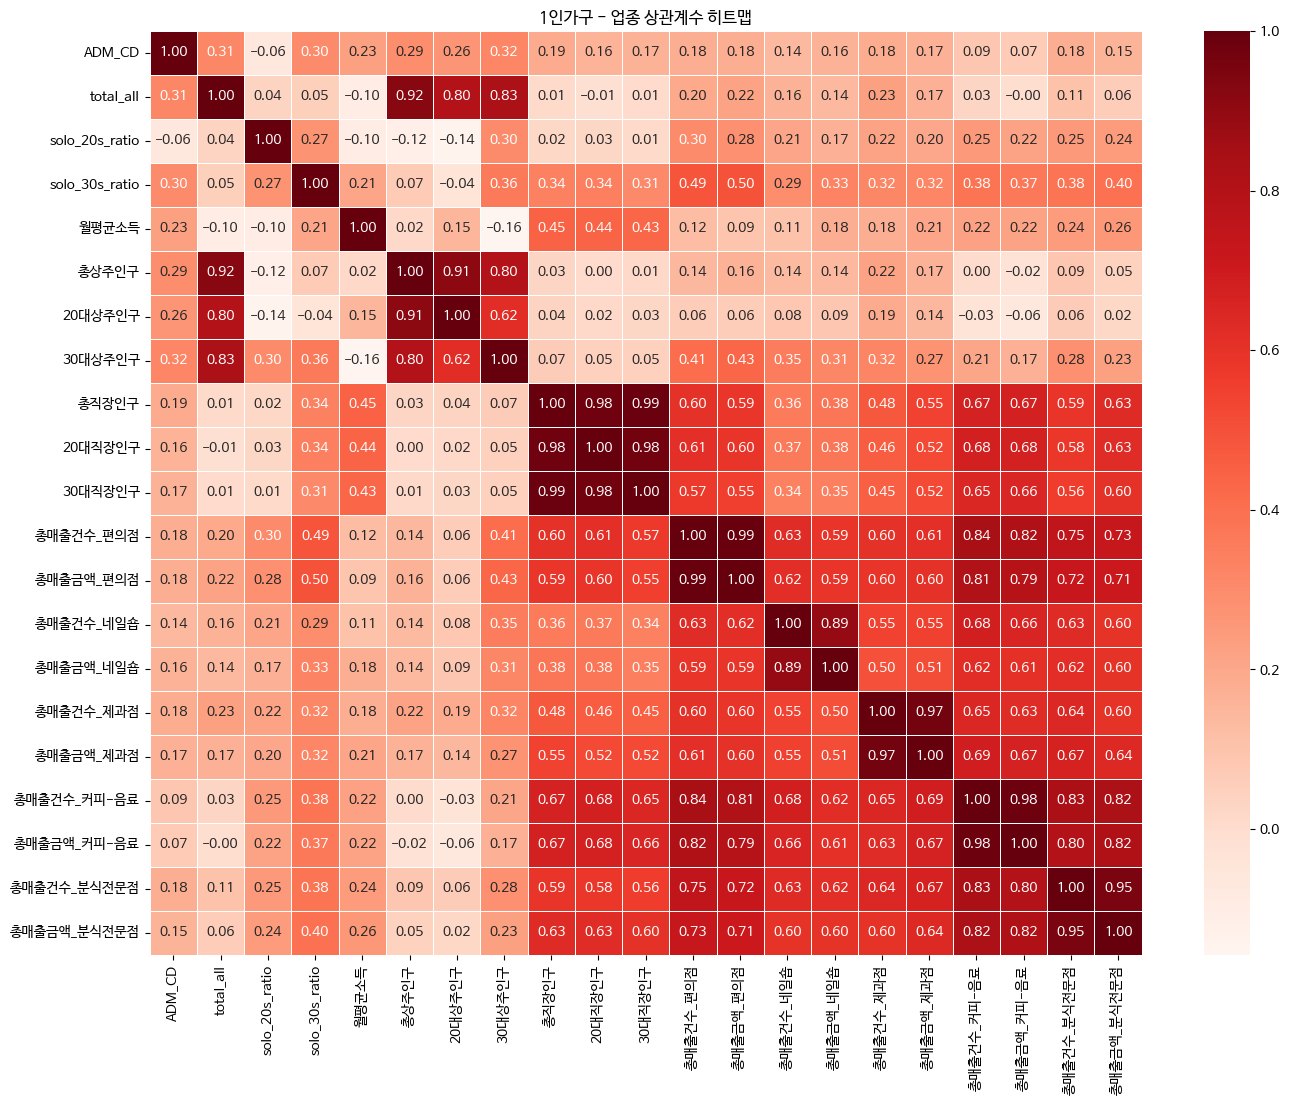

In [16]:
temp_corr = df_selected.corr(numeric_only = True)

# 히트맵 그리기
plt.figure(figsize=(16, 12))
sns.heatmap(temp_corr, annot=True, cmap='Reds', fmt=".2f", linewidths=0.5)
plt.title("1인가구 - 업종 상관계수 히트맵")
plt.savefig(f'{final_sang}/업종_상관관계.png', format='png')
plt.show()

In [17]:
### Outlier detection

Q1 = df_selected[['월평균소득', '총상주인구', '총직장인구']].quantile(0.25)
Q3 = df_selected[['월평균소득', '총상주인구', '총직장인구']].quantile(0.75)


IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


outliers_mask = ((df_selected[['월평균소득', '총상주인구', '총직장인구']] < lower_bound) | (df_selected[['월평균소득', '총상주인구', '총직장인구']] > upper_bound)).any(axis=1)

cleaned_df_selected = df_selected[~outliers_mask]